<a href="https://colab.research.google.com/github/yohanesnuwara/66DaysOfData/blob/main/D08_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Classification

I would like to review various metrics for multiclass classification: Precision, Recall, Accuracy, F1 score, ROC AUC, Cohen's Kappa, Matthew's Correlation Coefficient, and Log loss.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import log_loss, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

Access diamonds dataset.

In [2]:
url = 'https://raw.githubusercontent.com/yohanesnuwara/datasets/master/diamonds.csv'

df = pd.read_csv(url)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.798,0.474,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749,1.433,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457,2.234,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.800,3989.440,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731,1.122,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.735,1.142,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.539,0.706,0.0,2.91,3.53,4.04,31.80


The dataset consists of categorical and numerical features.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


Plot bar chart of target labels.

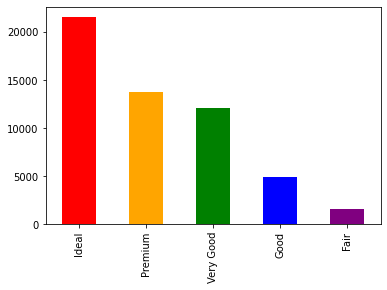

In [18]:
color = ['red', 'orange', 'green', 'blue', 'purple']
df.cut.value_counts().plot(kind='bar', color=color);

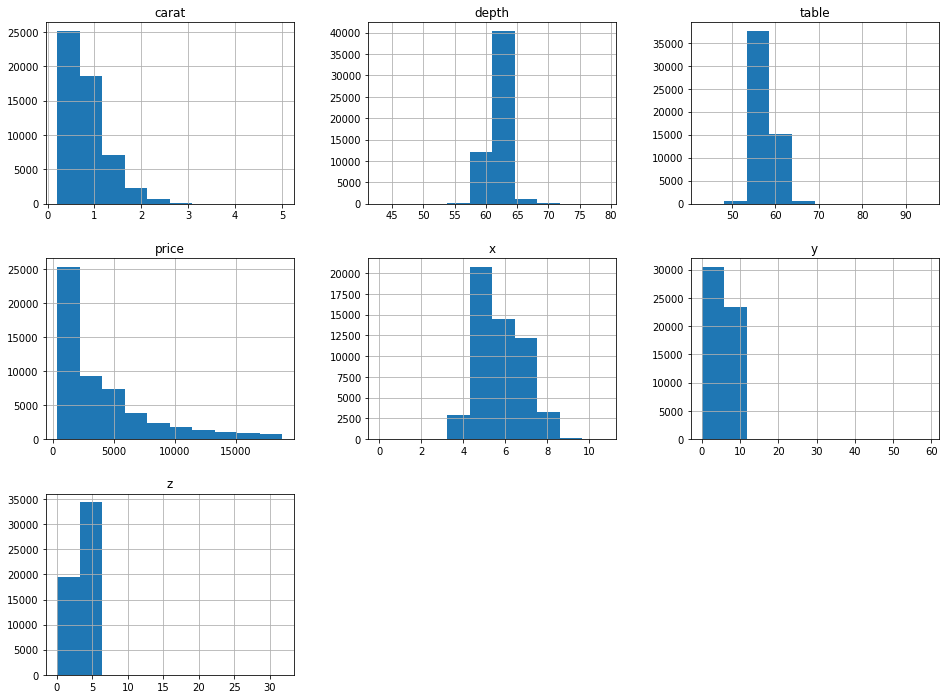

In [6]:
df.hist(figsize=(16, 12));

In [7]:
# Build feature/target arrays
X, y = df.drop("cut", axis=1), df["cut"]

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, 
                                                    test_size=0.33, stratify=y)

In [8]:
# Build categorical preprocessor
categorical_cols = X.select_dtypes(include="object").columns.to_list()
categorical_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown="ignore")
  )

# Build numeric processor
to_log = ["price", "carat"]
to_scale = ["x", "y", "z", "depth", "table"]
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())

# Full processor
full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, categorical_cols),
        ("power_transform", numeric_pipe_1, to_log),
        ("standardization", numeric_pipe_2, to_scale),
    ]
)

# Final pipeline combined with RandomForest
pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            RandomForestClassifier(max_depth=13),
        ),
    ]
)

# Fit
_ = pipeline.fit(X_train, y_train)

Plot confusion matrix.

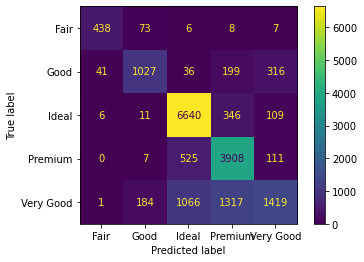

In [9]:
# Predict
y_pred = pipeline.predict(X_test)

plot_confusion_matrix(pipeline, X_test, y_test, 
                      values_format = '.5g') # .5g to suppress scientific notation
plt.show()

3 basic metrics:

* **Precision**: what proportion of predicted Positives is truly Positive?
* **Recall**: what proportion of actual Positives is correctly classified?
* **Accuracy**: what proportion of both Positive and Negative were correctly classified? (Often, a misleading metric)
* **F1 score**: harmonic mean of Precision and Recall, to trade-off both metrics

Each class has these metrics. 

Then each class metric is averaged with 3 methods: 

* **Macro**: simple arithmetic mean, doesn't give any weight. Only for balanced class, for imbalanced class this is not accurate.
* **Weighted**: harmonic mean, give weight by number of true classes
* **Micro**: Similar to Accuracy, a misleading metric

In [10]:
# Precision, recall, F1 score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Fair       0.90      0.82      0.86       532
        Good       0.79      0.63      0.70      1619
       Ideal       0.80      0.93      0.86      7112
     Premium       0.68      0.86      0.76      4551
   Very Good       0.72      0.36      0.48      3987

    accuracy                           0.75     17801
   macro avg       0.78      0.72      0.73     17801
weighted avg       0.75      0.75      0.73     17801



In [11]:
# Generate class membership probabilities
y_pred_probs = pipeline.predict_proba(X_test)

# Example prediction for observation no. 10
no_obs = 3
classes = ['Fair', 'Good', 'Ideal', 'Premium', 'Very Good']
for i in range(len(classes)):
  print(f'{classes[i]}: {y_pred_probs[no_obs-1][i]:.3f}')

Fair: 0.000
Good: 0.004
Ideal: 0.842
Premium: 0.028
Very Good: 0.126


ROC AUC score.

In [12]:
roc_auc_score(y_test, y_pred_probs, average="weighted", multi_class="ovr")

0.9115387585517636

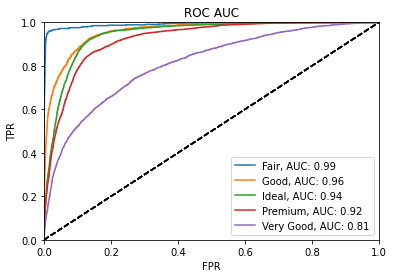

In [13]:
# For each class
for i in range(len(classes)):
  # Calculate False Positive Rate, True Negative Rate
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,i], 
                                   pos_label = classes[i]) 
  
  # Calculate AUC
  auroc = auc(fpr, tpr)
  
  # Plot ROC AUC curve for each class
  plt.plot(fpr, tpr, label=f'{classes[i]}, AUC: {auroc:.2f}')
  plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC AUC')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.xlim(0,1); plt.ylim(0,1)
plt.legend()
plt.show()

Cohen's Kappa score.

In [14]:
cohen_kappa_score(y_test, y_pred)

0.6489668766616736

Matthew's Correlation Coefficient.

In [15]:
matthews_corrcoef(y_test, y_pred)

0.6600019456000756

Log loss score.

In [16]:
log_loss(y_test, y_pred_probs)

0.6795797650637925

How is each metric exactly used?

* Compare one classifier’s overall performance to another in a single metric — use **Matthew’s correlation coefficient**, **Cohen’s kappa**, and **log loss**.
* Measure a classifier’s ability to differentiate between each class in balanced classification: **ROC AUC score**
* A metric that minimizes false positives and false negatives in imbalanced classification: **F1 score**
* Focus on decreasing the false positives of a single class: **Precision** for that class
* Focus on decreasing the false negatives of a single class: **Recall** for that class.



References:
* All in one: Precision, Recall, Accuracy, F1 score, Cohen Kappa, Matthew's correlation, and log loss: 
  * https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd
  * https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362

* Other resources:
  * Concepts about Precision, Recall, Accuracy: https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2
  * Concept about F1 score and averaging (weighted/macro/micro): https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
  * Concept about Cohen Kappa: https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c


